In [1]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField, TabularDataset
from torchtext.data import BucketIterator, Iterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import spacy
import re
import pickle
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('data/train_0.csv')

In [45]:
df.head()

,uuid,comment_text,toxicity
0,0fdd21db-2d15-458e-96b1-542840fc6ae8,and tyrrell was its head nutcase,0.0
1,988b4e95-8c6e-4cc3-9cb5-0848fec3c256,sockpuppet template i have to give it to you ...,0.0
2,7a57976f-c084-4a9b-b226-8391699468c9,invitation to take part in a study i am a wik...,0.0
3,7e21814e-4756-425a-8c24-74d424699aa2,here you are you stupid monkey,0.0
4,90bfe31f-8ab4-4386-8d34-cf8f9e708cbb,wpgm new monthly newsletter ctrb er if you do...,0.0


In [46]:
df = df.drop_duplicates(['comment_text', 'toxicity'])

In [47]:
tmp = df[df['comment_text'].duplicated(keep=False)].groupby('comment_text').max()

In [48]:
tmp_dct = tmp[['toxicity']].to_dict()['toxicity']

In [49]:
df['toxicity'] = df['comment_text'].map(tmp_dct).fillna(df['toxicity'])

In [52]:
df

,uuid,comment_text,toxicity
0,0fdd21db-2d15-458e-96b1-542840fc6ae8,and tyrrell was its head nutcase,0.0
1,988b4e95-8c6e-4cc3-9cb5-0848fec3c256,sockpuppet template i have to give it to you ...,0.0
2,7a57976f-c084-4a9b-b226-8391699468c9,invitation to take part in a study i am a wik...,0.0
3,7e21814e-4756-425a-8c24-74d424699aa2,here you are you stupid monkey,0.0
4,90bfe31f-8ab4-4386-8d34-cf8f9e708cbb,wpgm new monthly newsletter ctrb er if you do...,0.0
...,...,...,...
34642,7b41d05d-3ef0-49b9-9871-c0b1cebac226,nigel is a crazy idiot,2.0
34643,14dc574c-61c4-4d30-af19-997d92883d13,well now don t i feel stupid,1.0
34644,a3514de6-19d1-4908-b462-479c15eef9c1,fourth baldrick possibly being cleverer than...,1.0
34645,d5eaf094-6868-4496-b8d9-f2f3c650e913,iran that s right iran it was our drone an...,2.0


In [53]:
df['toxicity'].value_counts()

0.0    16328
1.0     6681
3.0     5129
2.0     4076
4.0     1938
5.0      451
Name: toxicity, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
train, val = train_test_split(df, test_size=0.1, stratify=df['toxicity'])

In [57]:
train.to_csv('data/train.csv', index=False)

In [58]:
val.to_csv('data/val.csv', index=False)

In [62]:
import spacy

In [63]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

In [64]:
def text_cleaner(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    return text.strip()

def tokenizer(s): 
    return [w.text.lower() for w in nlp(text_cleaner(s))]

In [65]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, lower=True)
LABEL = LabelField(sequential=False, use_vocab=False, dtype=torch.float,)

In [66]:
trn, vld = TabularDataset.splits(skip_header=True,
        path='data/', train='train.csv', validation='val.csv', format='csv',
        fields=[('uuid', None), ('comment_text', TEXT), ('toxicity', LABEL)])

In [67]:
with open('data/dataset_316011_2.txt', 'r') as f:
    test_file = f.read().split('\n')
    
test_file= test_file[:-1]
test_df = pd.DataFrame({'comment_text': test_file})
test_df.to_csv('data/test.csv', index=False)

tst = TabularDataset(
           path="data/test.csv", 
           format='csv',
           skip_header=True,
           fields=[('comment_text', TEXT)]
)

In [68]:
from torchtext import vocab

In [69]:
vec = vocab.Vectors('crawl-300d-2M-subword.vec', './data')

100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [03:44<00:00, 8905.96it/s]


In [70]:
%%time
TEXT.build_vocab(trn, vld, tst, vectors=vec)

Wall time: 1.11 s


In [71]:
print(TEXT.vocab.vectors.shape)

torch.Size([69778, 300])


In [72]:
TEXT.vocab.vectors[TEXT.vocab.stoi['word']]

tensor([ 0.0642,  0.0233,  0.0933, -0.0364,  0.0180, -0.0550,  0.1413,  0.0361,
         0.0221, -0.0311, -0.0238,  0.0797, -0.0133,  0.0260, -0.0029,  0.0269,
         0.1007, -0.0038, -0.0478,  0.0150,  0.0241,  0.1228,  0.0348, -0.0354,
         0.0108,  0.0330, -0.0473,  0.0132,  0.0151,  0.0149, -0.0583, -0.0174,
        -0.0159, -0.0640,  0.0725,  0.0829,  0.0131,  0.0503,  0.0154, -0.0650,
        -0.1467, -0.2259, -0.0142, -0.0125, -0.1148,  0.1187, -0.1453,  0.0106,
        -0.0220, -0.1520, -0.0330, -0.0487,  0.1099, -0.0253, -0.0775, -0.0521,
         0.0212, -0.0130, -0.1250,  0.0969,  0.0724, -0.0123, -0.1514, -0.0811,
        -0.1173,  0.0757,  0.0729, -0.1476,  0.0393, -0.1193, -0.0063, -0.0470,
         0.0992, -0.0473, -0.0045,  0.0036,  0.0222, -0.0331,  0.1007,  0.0158,
         0.0346, -0.0280,  0.0192, -0.0565, -0.0075, -0.0396, -0.0334, -0.0024,
        -0.0335,  0.0136,  0.0022,  0.0309, -0.0216,  0.0442, -0.0203,  0.2769,
         0.0393,  0.0958,  0.0570, -0.03

In [73]:
LABEL.build_vocab(trn)

In [74]:
len(TEXT.vocab), len(LABEL.vocab)

(69778, 6)

In [75]:
TEXT.vocab.freqs.most_common(10)

[('the', 99314),
 ('you', 79331),
 ('i', 64147),
 ('to', 62761),
 ('a', 57499),
 ('and', 52105),
 ('of', 46456),
 ('is', 43322),
 ('that', 33922),
 ('fuck', 33046)]

In [76]:
LABEL.vocab.freqs.most_common()

[('0.0', 14695),
 ('1.0', 6013),
 ('3.0', 4616),
 ('2.0', 3668),
 ('4.0', 1744),
 ('5.0', 406)]

In [77]:
device='cuda'

In [122]:
batch_size = 32

In [78]:
train_iter, val_iter = BucketIterator.splits(
        (trn, vld),
        batch_sizes=(batch_size, batch_size),
        sort_key= lambda x: len(x.comment_text),
        sort_within_batch=True,
        device=device,
        repeat=False,
)

In [79]:
vocab_size = len(TEXT.vocab)
num_classes = len(LABEL.vocab)

In [80]:
vocab_size, num_classes

(69778, 6)

In [81]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [388]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size, pretrained_vecs):
        super(RNNBaseline, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self.embed.weight.data.copy_(pretrained_vecs)
        self.embed.weight.requires_grad = False
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=False, bidirectional=True)
        self.fc_1 = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.fc_2 = nn.Linear(2*hidden_dim, 6)
        self.dropout = nn.Dropout(0.85)
        
            
    def forward(self, seq, lens):
        lens_clamped = lens.clamp(min=1)
        embeds = self.embed(seq)
        embeds = pack_padded_sequence(embeds, lens_clamped, enforce_sorted=False)
        gru_out, h = self.gru(embeds)
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim = 1)
        x = F.leaky_relu(self.dropout(self.fc_1(h)))
        preds = self.fc_2(x).view(-1, 6)
        return preds

In [389]:
em_sz = 300
nh = 300

model_base = RNNBaseline(nh, emb_dim=em_sz, vocab_size=vocab_size, 
                    pretrained_vecs=TEXT.vocab.vectors).to(device)

In [390]:
model_base.cuda()


RNNBaseline(
  (embed): Embedding(69778, 300, padding_idx=1)
  (gru): GRU(300, 300, bidirectional=True)
  (fc_1): Linear(in_features=600, out_features=600, bias=True)
  (fc_2): Linear(in_features=600, out_features=6, bias=True)
  (dropout): Dropout(p=0.85, inplace=False)
)

In [391]:
opt = optim.Adam(filter(lambda p: p.requires_grad, model_base.parameters()), lr=3e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [392]:
epochs = 15
train_losses = [] 
val_losses = []

In [393]:
%%time
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model_base.train() 
        for i, batch in enumerate(train_iter): 
            x, lens = batch.comment_text
            y = batch.toxicity.long()

            opt.zero_grad()
            preds = model_base(x, lens)
            loss = loss_func(preds, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_iter)
        train_losses.append(epoch_loss)

        val_loss = 0.0
        val_true = 0.0
        val_overall = len(vld)
        model_base.eval()
        for j, batch in enumerate(val_iter):
            with torch.no_grad():
                x, lens = batch.comment_text
                y = batch.toxicity.long()
                preds = model_base(x, lens) 
                val_true += torch.sum(torch.argmax(preds, axis=1) == y)
                loss = loss_func(preds, y.long())
                val_loss += loss.item()
        val_acc = val_true / val_overall
        val_loss /= len(val_iter)
        val_losses.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}, Validation accuracy {}'.format(epoch, epoch_loss, val_loss, val_acc))

Epoch: 1, Training Loss: 0.9281373527627707, Validation Loss: 0.8181389728817371, Validation accuracy 0.6680150032043457
Epoch: 2, Training Loss: 0.8118000953655223, Validation Loss: 0.7503259037065944, Validation accuracy 0.6821727752685547
Epoch: 3, Training Loss: 0.7869700484696844, Validation Loss: 0.7573552798787389, Validation accuracy 0.6836174726486206
Epoch: 4, Training Loss: 0.7650024578189458, Validation Loss: 0.7433082491432855, Validation accuracy 0.6847732067108154
Epoch: 5, Training Loss: 0.7414230403530524, Validation Loss: 0.730378668516054, Validation accuracy 0.6865068078041077
Epoch: 6, Training Loss: 0.8191671492474525, Validation Loss: 0.7565885336574064, Validation accuracy 0.6919965147972107
Epoch: 7, Training Loss: 0.7939035538775231, Validation Loss: 0.7389748093731906, Validation accuracy 0.6836174726486206
Epoch: 8, Training Loss: 0.7654364436283494, Validation Loss: 0.7334174439994567, Validation accuracy 0.689685046672821
Epoch: 9, Training Loss: 0.7502840

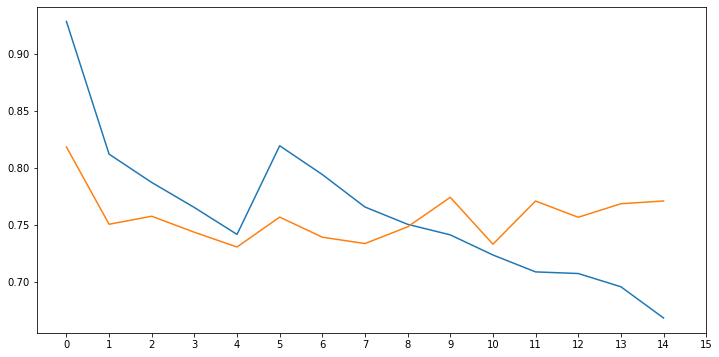

In [394]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)
ticks = plt.xticks(range(epochs + 1))

In [406]:
with open('data/dataset_316011_2.txt', 'r') as f:
    test_file = f.read().split('\n')

In [407]:
test_file= test_file[:-1]

In [408]:
len(test_file)

9194

In [409]:
test_df = pd.DataFrame({'comment_text': test_file})

In [410]:
test_df.head()

,comment_text
0,that s great many thanks pigsonthewing talk ...
1,hey thanks i m sure this account will get b...
2,yes i mentioned that in the latest afd how d...
3,nice try i just asked why the word terrorist w...
4,adoption can you adopt me please


In [411]:
test_df.tail(2)

,comment_text
9192,ignore the islamophobes you are truly a warrio...
9193,i think me and justin are going to try and get...


In [412]:
test_df.to_csv('data/test.csv', index=False)

In [413]:
tst = TabularDataset(
           path="data/test.csv",
           format='csv',
           skip_header=True,
           fields=[('comment_text', TEXT)]
)

In [414]:
tst_iter = Iterator(
        tst,
        batch_size=64,
        sort=False,
        sort_key= lambda x: len(x.comment_text),
        sort_within_batch=False,
        device=device,
        train=False,
        repeat=False,
)


In [415]:
test_preds = np.zeros(len(tst))
model_base.eval()
for i, batch in enumerate(tst_iter):
    with torch.no_grad():
        x, lens = batch.comment_text
        y_pred = torch.argmax(model_base(x, lens).detach().cpu(), axis=1)
        test_preds[i*64:min((i+1)*64, i*64+len(x))] = y_pred

In [416]:
test_preds = test_preds.astype(int)

In [417]:
len(test_preds)

9194

In [418]:
np.savetxt('data/submission.txt', test_preds, fmt='%d')

In [320]:
val

,uuid,comment_text,toxicity
25574,dbdef750-57db-465e-b341-ada60acac237,screw off i ll do what i want southwest does...,3.0
2936,61e627e9-4b07-4daf-811c-25ffc64a0665,tagging of enlisy i recently removed a speedy...,0.0
4369,45670a32-d24d-4773-aca1-1d147f985e90,the capital of ukraine is the city of kyiv art...,0.0
10090,9aed697f-d14d-4748-9400-adc1f4a26e36,re wording according to the european commiss...,0.0
3060,ef5345bb-4ea8-4903-9475-2e35119fac1d,do not erase my messages this behaviour is inf...,0.0
...,...,...,...
33081,38058a78-12f7-449c-b4e6-c5fa2b182b5f,aol ip block another aol ip block and such fo...,1.0
17222,a7941588-be52-4aed-8da3-2d8f8668dfff,fuck you learn how to type a url correctly y...,4.0
15213,34cd61b4-5ba6-429b-8bd2-258d03f30786,doesn t surprise me one of the side effects o...,0.0
29088,1d9a26bb-a76b-461a-95ad-4fac55e9d21a,this is a stupid idea all it is doing is addi...,1.0
